In [3]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import crossprob
from tqdm import tqdm
import random
import pickle as pkl

from prompt_risk.bounds import *
from prompt_risk.utils import *

from matplotlib import style
plt.style.use('seaborn-v0_8')

In [271]:
measures_map = {
    "var": "VaR",
    "cvar": "CVaR"
}

def sample_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def plot_results(
    dataset = "red_team_chat",
    model_size = "large",
    loss_fn = "toxicity",
    n_cal = 1500,
    n_ex=1,
    delta = 0.05,
    num_hypotheses = 50,
    measure="cvar",
    beta_min=0.8, 
    beta_max=1.0, 
    xlim_min=0.0,
    xlim_max=1.0,
    left_title=None,
    right_title=None,
    alpha=0.1,
    interest_inds=[0,1],
    skip_set = [],
    save_result = False
):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    load_folder = "../output/{}".format(
        dataset, 
    )
    load_root = "{}/{}_model_{}_{}_loss_dist_with_text.pkl".format(
        load_folder,
        dataset, 
        model_size, 
        loss_fn
    )
    print("loading from", load_root)
    
    with open(load_root, 'rb') as file:
        res = pkl.load(file)
    
    bj_bounds = dict()
    correction = delta/(num_hypotheses-len(skip_set))

    stats = []
    
    plt.rcParams["figure.figsize"] = [12,2.5]
    fig, axs = plt.subplots(1,3)
    plot_dist_idx = [1,12]

    ins_idx = 0
    disp_idx = 0
    
    for instruction, X, query_texts, chat_responses in res:

        if ins_idx in skip_set:
            ins_idx += 1
            continue

        X_cal = X[:n_cal]
        X_test = X[n_cal:]
    
        text_cal = query_texts[:n_cal]
        text_test = query_texts[n_cal:]
    
        chat_out_cal = chat_responses[:n_cal]
        chat_out_test = chat_responses[n_cal:]        
    
        n_test = X_test.shape[0]
        
        assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        assert len(chat_out_cal) == n_cal and len(chat_out_test) == n_test
        assert len(text_cal) == n_cal and len(text_test) == n_test
    
        if X_cal.shape[0] not in bj_bounds:
            b = berk_jones(n_cal, correction)
            bj_bounds[n_cal] = b
        else:
            b = bj_bounds[n_cal]
        
        t_cal = np.linspace(0.0, 1.0, n_cal)
        X_cal_sorted = np.sort(X_cal, axis=-1)
        
        t_test = np.linspace(0.0, 1.0, n_test)
        test_ind_sorted = np.argsort(X_test, axis=-1)
        X_test_sorted = X_test[test_ind_sorted]

        emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
        emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]

        if measure == "mean":
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            emp_val_cal = emp_mean_cal
            emp_val_test = emp_mean_test
        elif measure == "var":
            bound_val = X_cal_sorted[(b < beta_min).astype(int).sum()]
            emp_val_cal = np.quantile(X_cal_sorted, beta_min)
            emp_val_test = np.quantile(X_test_sorted, beta_min)
        elif measure in "cvar" or "var-int":
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]
        elif measure == "gini":
            bound_val = calc_gini(np.expand_dims(X_cal, 0), b)[0]
            emp_val_cal = sample_gini(X_cal)
            emp_val_test = sample_gini(X_test)
        else:
            raise ValueError

        s = {
            "idx": ins_idx,
            "emp_mean_cal": emp_mean_cal,
            "measure_bound": bound_val,
            "emp_meas_cal": emp_val_cal,
            "emp_meas_test": emp_val_test,
        }
        stats.append(s)

        wind = 3

        
        
        if ins_idx in interest_inds:
            
            # axs[1].plot(X_cal_sorted, b, "--", label="p{} bound".format(ins_idx), color=pal[ins_idx])
            # axs[1].plot(X_cal_sorted, np.arange(n_cal)/n_cal, label="p{} empirical".format(ins_idx), color=pal[ins_idx])
    
            axs[1].plot(b, X_cal_sorted, "--", label=r"$B^U_{}$".format(disp_idx), color=pal[disp_idx])
            axs[1].plot(np.arange(n_cal)/n_cal, X_cal_sorted, label=r"$F^-_{}$".format(disp_idx), color=pal[disp_idx])

            axs[2].plot(b, X_cal_sorted, "--", label=r"$B^U_{}$".format(disp_idx), color=pal[interest_inds.index(ins_idx)])
            axs[2].plot(np.arange(n_cal)/n_cal, X_cal_sorted, label=r"$p_{}$ empirical".format(disp_idx), color=pal[disp_idx])

            low_var_ind = int(X_test.shape[0]*(1-beta_min))
            var_text = [text_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(low_var_ind-wind, low_var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(low_var_ind-wind, low_var_ind+wind+1)]

            axs[0].scatter(
                emp_mean_cal, bound_val, 
                label=r"$\hat R(p_{})$".format(disp_idx), 
                color=pal[disp_idx], 
                marker="P", 
                # zorder=1000, 
                s=250
            )
            
            # print("Text@Low VaR:", 1-beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            # print()
            
            var_ind = int(X_test.shape[0]*beta_min)
            var_text = [text_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(var_ind-wind, var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(var_ind-wind, var_ind+wind+1)]
            # print("Text@VaR:", beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            disp_idx += 1

        ins_idx += 1

        # if len(stats) >= n_ex:
        #     break

    for s in stats:
        print(s)

    emp_means = [v["emp_mean_cal"] for v in stats]
    measure_bounds = [v["measure_bound"] for v in stats]
    emp_measure_cal = [v["emp_meas_cal"] for v in stats]
    emp_measure_test = [v["emp_meas_test"] for v in stats]

    axs[0].scatter(emp_means, measure_bounds, color=pal[2], label=r"$\hat R(p_i)$")
    axs[0].set_ylim(min(measure_bounds)-0.1, min([max(measure_bounds)+0.2, 1.0]))
    
    axs[0].plot([min(emp_means),max(emp_means)], [alpha, alpha], "--", color=pal[3], label=r"$\alpha$")
    axs[0].set_xlabel("Emp. Mean on Calibration Set")
    # axs[0].set_ylabel(r"$\hat R$")
    axs[0].set_ylabel(measures_map[measure] + " Risk")

    axs[1].set_xlabel(r"$\beta$ (Quantile)")
    axs[1].set_ylabel("Loss Value")

    axs[2].set_xlabel(r"$\beta$ (Quantile)")

    # for ax in axs[1:]:
    axs[0].legend(loc="upper right", ncols=2, frameon=True)
    axs[1].legend(loc="upper left", ncols=2, frameon=True)

    axs[0].set_title(left_title)
    axs[1].set_title("Inverse CDF and Bound")
    if right_title is None:
        axs[2].set_title("Inverse CDF and Bound (Zoom)")
    else:
        axs[2].set_title(right_title)

    if measure == "var":
        axs[2].set_xlim(beta_min-0.05, beta_min+0.05)
        axs[2].plot([beta_min, beta_min], [0,1], "--", color="k")
    else:
        axs[2].set_xlim(beta_min, 1)

    if save_result:
        save_root  = "../plots/{}/{}_model_{}_{}_{}_loss_dist_with_text.png".format(
            dataset,
            dataset, 
            model_size, 
            loss_fn,
            measure,
        )
        plt.savefig(save_root, bbox_inches="tight")

    plt.show()

loading from ../output/red_team_chat/red_team_chat_model_xl_toxicity_loss_dist_with_text.pkl
{'idx': 1, 'emp_mean_cal': 0.049345790793025625, 'measure_bound': 0.7909523448211802, 'emp_meas_cal': 0.44547128375761574, 'emp_meas_test': 0.5014668140890298}
{'idx': 3, 'emp_mean_cal': 0.047915719540972714, 'measure_bound': 0.7452336189859242, 'emp_meas_cal': 0.42376614632253023, 'emp_meas_test': 0.4857514002820952}
{'idx': 4, 'emp_mean_cal': 0.047159198129513295, 'measure_bound': 0.817628656464627, 'emp_meas_cal': 0.4450663731980307, 'emp_meas_test': 0.4007412351706415}
{'idx': 11, 'emp_mean_cal': 0.04892472534980314, 'measure_bound': 0.8283921594358061, 'emp_meas_cal': 0.4583100511996691, 'emp_meas_test': 0.453786978937575}
{'idx': 12, 'emp_mean_cal': 0.048400944198564874, 'measure_bound': 0.7572271557196225, 'emp_meas_cal': 0.42725151126274913, 'emp_meas_test': 0.5609195169685116}


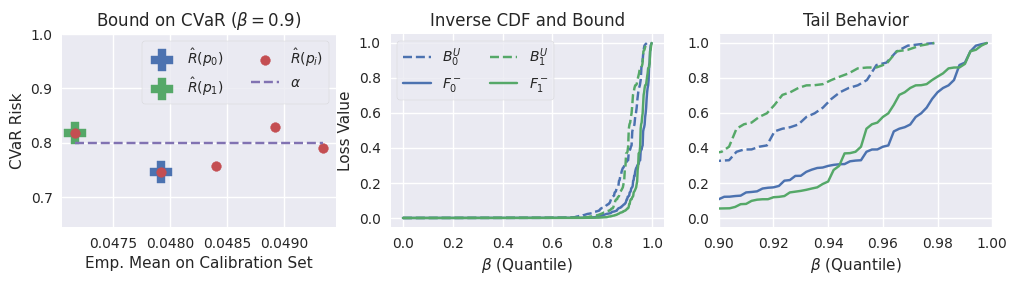

In [272]:
plot_results(
    dataset = "red_team_chat",
    model_size = "xl",
    loss_fn = "toxicity",
    measure="cvar",
    beta_min = 0.9,
    n_cal=500,
    n_ex=2,
    left_title=r"Bound on CVaR ($\beta=0.9$)",
    right_title=r"Tail Behavior",
    alpha=0.8,
    interest_inds = [3,4],
    skip_set = [0,2,5,6,7,8,9,10,13,14],
    save_result=True
)

loading from ../output/full_chat/full_chat_model_xl_toxicity_loss_dist_with_text.pkl
{'idx': 1, 'emp_mean_cal': 0.019993380364741454, 'measure_bound': 0.2602517008781433, 'emp_meas_cal': 0.07750514894723884, 'emp_meas_test': 0.0805260967463254}
{'idx': 5, 'emp_mean_cal': 0.02197118230209266, 'measure_bound': 0.35268300771713257, 'emp_meas_cal': 0.12145651802420614, 'emp_meas_test': 0.1522761575877666}
{'idx': 6, 'emp_mean_cal': 0.02130153178612844, 'measure_bound': 0.32618895173072815, 'emp_meas_cal': 0.0932713046669955, 'emp_meas_test': 0.0671827815473079}
{'idx': 7, 'emp_mean_cal': 0.022901510632467804, 'measure_bound': 0.32618895173072815, 'emp_meas_cal': 0.07945334725081908, 'emp_meas_test': 0.05856813080608844}
{'idx': 11, 'emp_mean_cal': 0.019015607082350706, 'measure_bound': 0.3183279037475586, 'emp_meas_cal': 0.0581520015373826, 'emp_meas_test': 0.07712349258363242}


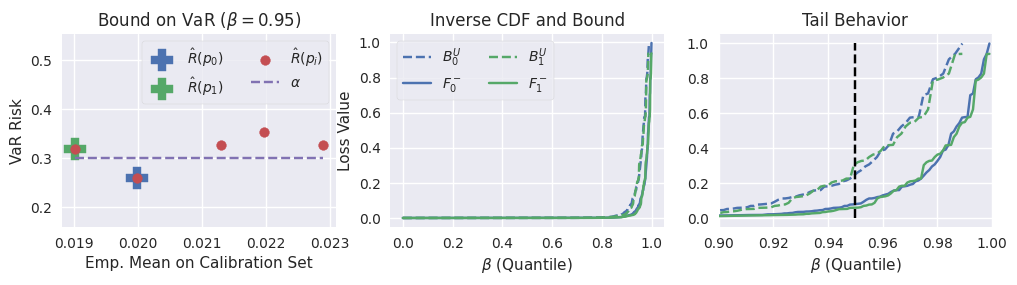

In [273]:
plot_results(
    dataset = "full_chat",
    model_size = "xl",
    loss_fn = "toxicity",
    measure="var",
    beta_min = 0.95,
    n_cal=1000,
    n_ex=2,
    left_title=r"Bound on VaR ($\beta=0.95$)",
    right_title=r"Tail Behavior",
    alpha=0.3,
    interest_inds = [1,11],
    skip_set=[0,2,3,4,8,9,10,12],
    save_result=True
)